# Imperfect HWP simulation

Saved residuals to Hamal_residuals_Q_injected_1.0_matrix_noise_1_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0.npy
Saved residuals to Hamal_residuals_Q_injected_1.5_matrix_noise_1_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0.npy
Saved residuals to Hamal_residuals_Q_injected_2.0_matrix_noise_1_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0.npy
Saved residuals to Hamal_residuals_Q_injected_2.5_matrix_noise_1_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0.npy
Saved residuals to Hamal_residuals_Q_injected_3.0_matrix_noise_1_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0.npy


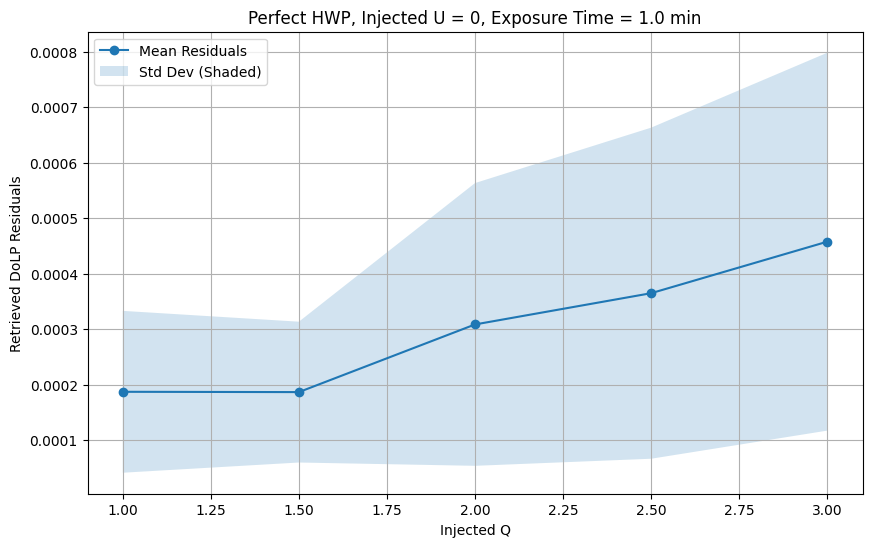

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 100

# Injected polarization range
Q_injected_values = np.arange(0.01, 0.031, 0.005)  # From 1% to 3% in increments of 0.5%
U_injected = 0
noise_percentage = 0  # Intensity noise
matrix_noise = 1  # Fixed matrix noise (0%)

# HWP settings
HWP_noise = 0  # 10% uncertainty on HWP retardance
delta_HWP = 0.5
num_trials = 50  # Number of trials per Q value

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over injected Q values
    for Q_injected in Q_injected_values:
        residuals = []

        # Perform multiple trials for each Q value
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this Q value
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save the residuals as a .npy file
        filename = (
            f"{target['name']}_residuals_Q_injected_{Q_injected*100:.1f}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"HWP_noise_{HWP_noise}_tint_{t_int}_sub_tint_{sub_tint}_"
            f"readout_noise_{noise_percentage}.npy"
        )
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)

    plt.plot(Q_injected_values * 100, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(Q_injected_values * 100, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"Injected Q")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Perfect HWP, Injected U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# Regenerating Plots

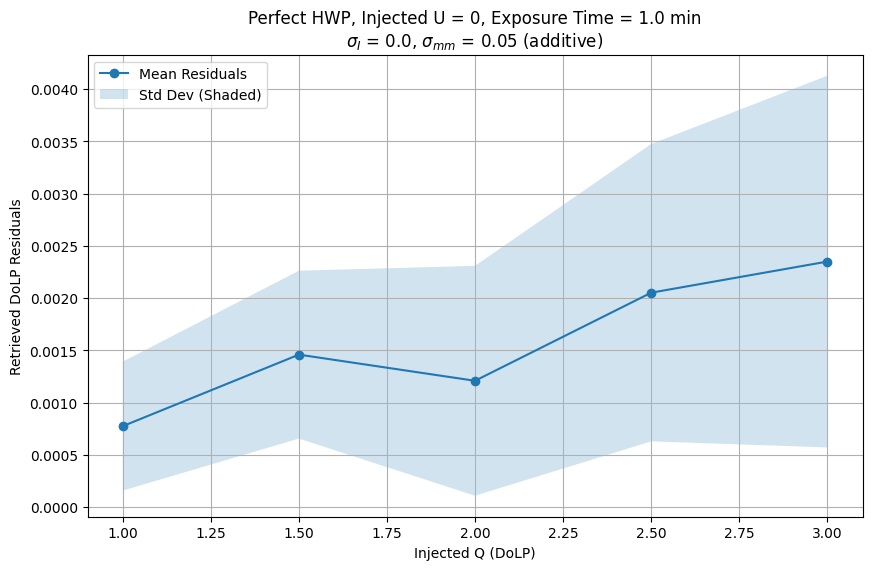

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define target parameters
targets = [
    {"name": "Hamal", "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Fixed parameters for filenames and plotting
Q_injected_values = np.arange(0.01, 0.031, 0.005)  # From 1% to 3% in increments of 0.5%
matrix_noise = 5  # Fixed matrix noise
matrix_noise_type = "additive"
HWP_noise = 0
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1
noise_percentage = 0

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over Q injected values and load corresponding residuals
    for Q_injected in Q_injected_values:
        filename = (
            f"{target['name']}_residuals_Q_injected_{Q_injected*100:.1f}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"HWP_noise_{HWP_noise}_tint_{t_int}_sub_tint_{sub_tint}_"
            f"readout_noise_{noise_percentage}.npy"
        )
        
        try:
            residuals = np.load(filename)
            mean_residuals.append(np.mean(residuals))
            std_residuals.append(np.std(residuals))
        except FileNotFoundError:
            print(f"File {filename} not found. Skipping this Q value.")
            mean_residuals.append(None)
            std_residuals.append(None)

    # Convert results to numpy arrays for plotting
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    plt.plot(Q_injected_values * 100, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(
        Q_injected_values * 100,
        mean_residuals - std_residuals,
        mean_residuals + std_residuals,
        alpha=0.2,
        label="Std Dev (Shaded)"
    )
    plt.xlabel(r"Injected Q (DoLP)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        f"Perfect HWP, Injected U = 0, Exposure Time = {t_int / 60:.1f} min\n"
        f"$\sigma_I$ = {noise_percentage:.1f}, $\sigma_{{mm}}$ = {(matrix_noise / 100)} ({matrix_noise_type})"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
